# CVPR Project

## Multi Model Fitting images

Iva Ilcheva<br>
Reinard Lazuardi Kuwandy

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2, ifft2
from scipy.signal import gaussian
import random
import math
%matplotlib inline

IMG_TARGET = 'img/target.jpg'
IMG_TEMPLATE = ['img/template1.png', 'img/template2.png', 'img/template3.png']

### Helper Functions

In [2]:
'''
    Read images.
'''
def read_images(img_path1, img_path2):
    img1 = cv.imread(img_path1)  
    img2 = cv.imread(img_path2) 
    
    return img1, img2  

In [3]:
'''
    Plot images.
'''
def plot_images(img_1, img_2):
    fx, plots = plt.subplots(1, 2, figsize=(20,10))
    plots[0].set_title("Target Image")
    plots[0].imshow(img_1)

    plots[1].set_title("Template Image")
    plots[1].imshow(img_2)

In [4]:
'''
    Find keypoints and descriptors with SIFT.
'''
def extract_keypoints_and_descriptors(img_1, img_2):
    sift = cv.xfeatures2d.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(img_1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img_2,None)
    
    return keypoints_1, descriptors_1, keypoints_2, descriptors_2

In [5]:
'''
    Find closest matches based on distance.
'''
def get_best_matches(descriptors_1, desriptors_2, ratio):
    bf = cv.BFMatcher(cv.NORM_L1, crossCheck = False)
    matches = bf.knnMatch(descriptors_1,desriptors_2,k=2)

    best_matches_1 = []
    plot_best_matches_1 = []

    for m,n in matches:
        if m.distance < ratio*n.distance:
            plot_best_matches_1.append([m])
            best_matches_1.append(m)
    
    return plot_best_matches_1, best_matches_1

In [6]:
'''
    Draw closest matches.
'''
def draw_closest_matches(img_1, img_2, keypoints_1, keypoints_2, plot_best_matches_1):
    img = cv.drawMatchesKnn(img_1,keypoints_1,img_2,keypoints_2,plot_best_matches_1,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize = (200,200))
    plt.imshow(img)
    plt.show()

In [7]:
'''
    Retrieve matching point correspondences' coordinates
    for each of the images.
'''
def get_correspondences(best_matches_1, keypoints_1, keypoints_2):
    
    correspondences_1 = []
    good = []
    
    for match in best_matches_1:

        img1_idx = match.queryIdx
        img2_idx = match.trainIdx

        (x1, y1) = keypoints_1[img1_idx].pt
        (x2, y2) = keypoints_2[img2_idx].pt

        correspondences_1.append([x2, y2, x1, y1])
        
    return correspondences_1

In [8]:
'''
    Function to estimate the error:
        || pH - p' ||
'''

def euclidean_distance(correspondence, homographyMatrix):
    
    actualP = np.transpose([correspondence[0], correspondence[1], 1])
    actualPPrime = np.transpose([correspondence[2], correspondence[3], 1])
    
    estimatedPPrime = np.dot(homographyMatrix, actualP)
    estimatedPPrime = estimatedPPrime/estimatedPPrime[2]

    error = np.linalg.norm(actualPPrime - estimatedPPrime)

    return error

In [9]:
'''
    Function to estimate the homography matrix H.
'''
def estimate_homography(correspondences):
    A = []
    
    for cor in correspondences:
        p1 = [cor[0], cor[1], 1]
        p2 = [cor[2], cor[3], 1]

        A.append([-p2[2] * p1[0], -p2[2] * p1[1], -p2[2] * p1[2], 0, 0, 0, p2[0] * p1[0], p2[0] * p1[1], p2[0] * p1[2]])
        A.append([0, 0, 0, -p2[2] * p1[0], -p2[2] * p1[1], -p2[2] * p1[2], p2[1] * p1[0], p2[1] * p1[1], p2[1] * p1[2]])

    U, diagonalMatrix, Vt = np.linalg.svd(A)

    homographyMatrix = (Vt[-1]/Vt[-1][-1]).reshape((3,3))  

    return homographyMatrix, diagonalMatrix

In [10]:
'''
    Function to compute new Loop Number
'''
def computeLoopNumber(sampleSize, confidence, pointNum, inlierNum):
    num = int(math.ceil(math.log10(1 - 0.01 * confidence) / math.log10(1 - float(inlierNum/pointNum)**sampleSize)))
    return num

In [11]:
'''
    Function to estimate a model via RANSAC.
'''
def ransac(point_correspondences, threshold=0.9, confidence=99, numTrials=1000, sample_size=4):
    max_inliers = []
    FIRST_SINGULAR_VALUE = 0
    LAST_SINGULAR_VALUE = None
    H = None
    D = None
    idxTrial = 1
    numPts = len(point_correspondences)
    
    
    while idxTrial <= numTrials:
    
#     for i in range(1000):
        
        '''
            Pick minimum set of 4 point correspondences
            and estimate a model.
        '''
        random_four_indices = random.sample(range(0, numPts), sample_size)
        random_four = [point_correspondences[i] for i in random_four_indices]

        
        ''' 
            Estimate homography matrix H,
            based on 4 picked points.
        '''
        current_H, current_D = estimate_homography(np.vstack(random_four))
        
        
        '''
            Find inliers within Euclidean distance of 5.
        '''
        inliers = []
        prefspace = []
        for i in range(len(point_correspondences)):
            distance = euclidean_distance(point_correspondences[i], current_H)
            if distance < threshold:
                inliers.append(point_correspondences[i])

        ''' 
            Always update current model,
            when a better one with more inliers
            is available.
        '''
        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            H = current_H
            D = current_D
            LAST_SINGULAR_VALUE = len(D)-1
            num = computeLoopNumber(sample_size, confidence, numPts, len(max_inliers))
            numTrials = min(numTrials, num)

        idxTrial = idxTrial + 1
        
        '''
            When inliers of best model so far reach a desired portion of
            all correspondences - conclude the search.
            As for the goodness of homography, the ratio between the first
            and last singular values (computed via SVD) should be below 10**15.
            Additionally, the det(H) should be near 0.
        '''
#         if len(max_inliers) > (len(point_correspondences)*threshold) and D[FIRST_SINGULAR_VALUE]/D[LAST_SINGULAR_VALUE] < 10 ** 15 and abs(np.linalg.det(H)) < 0.5:
#             break
            
            
    return H, max_inliers

In [12]:
'''
    Function to estimate all models until #min_correspondences (used for estimation) is reached.
'''
def sequential_ransac(correspondences, threshold, min_correspondences_count,confidence=99,numTrials=1000):
    
    models = []
    inliers = []
    epochs = 0
#     while len(correspondences) > min_correspondences_count or epochs > 10:
    while (len(correspondences) > min_correspondences_count) or (epochs > 10):
        H, inliers = ransac(correspondences, threshold, confidence, numTrials, min_correspondences_count)
        if len(inliers)/len(correspondences) > 0.05:
            models.append([H, inliers])
            
            correspondences = [i for i in correspondences if i not in inliers]
            print(len(correspondences))
            if len(correspondences) < min_correspondences_count:
                break
#             epochs -= 1
        else:
#             correspondences = [i for i in correspondences if i not in inliers]
            epochs += 1
    return models

In [43]:
'''
    Function to estimate all models until #min_correspondences (used for estimation) is reached.
'''
def plot_image_correspondences(img_target_plot, img_template_plot, models):
    
    inliers1 = []
    inliers2 = []

    fx, plots = plt.subplots(1, 2, figsize=(20,10))
    plots[0].set_title("Target Image")
    plots[1].set_title("Template Image")

    h,w = cv.cvtColor(img_template_plot, cv.COLOR_BGR2GRAY).shape
    pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    # Blue color in BGR 
    color = (255, 255, 255)

    # Line thickness of 2 px 
    thickness = 2

    for model in models:
        dst = cv.perspectiveTransform(pts,model[0])
        img_target_plot = cv.polylines(img_target_plot,[np.int32(dst)],True,color,3, cv.LINE_AA,)
        for inlier in model[1]:
            inliers1.append([inlier[2],inlier[3]])
            inliers2.append([inlier[0],inlier[1]])
            plots[1].scatter(*zip(*inliers2), color='red')
            plots[0].scatter(*zip(*inliers1), color='red')

    plots[0].imshow(img_target_plot)
    plots[1].imshow(img_template_plot)

### Implementation

In [44]:
img_target, img_template = read_images(IMG_TARGET, IMG_TEMPLATE[0])

In [19]:
img_template2, img_template3 = read_images(IMG_TEMPLATE[1], IMG_TEMPLATE[2])

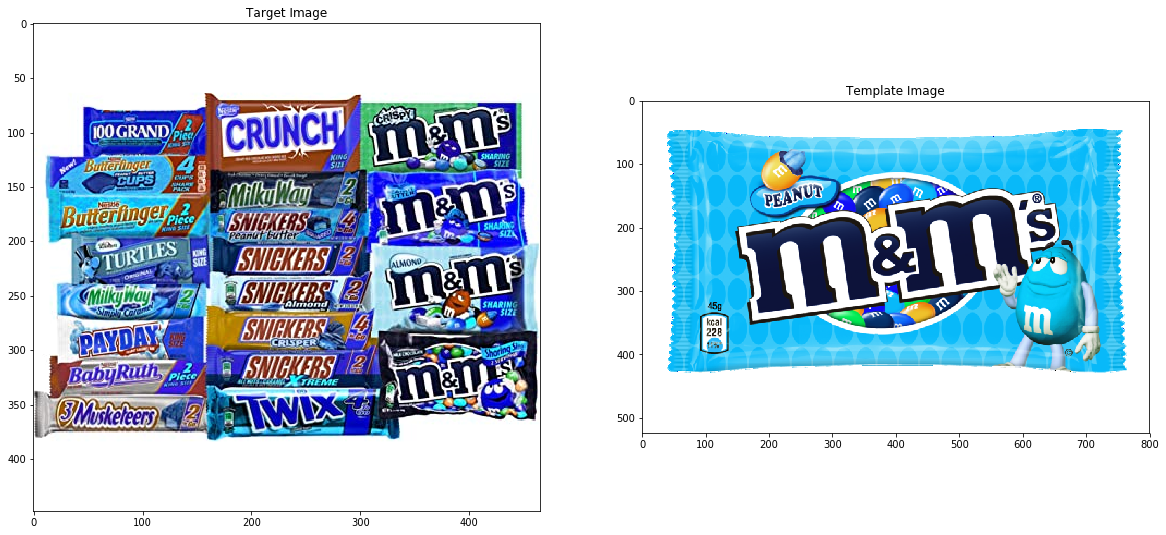

In [15]:
plot_images(img_target, img_template)

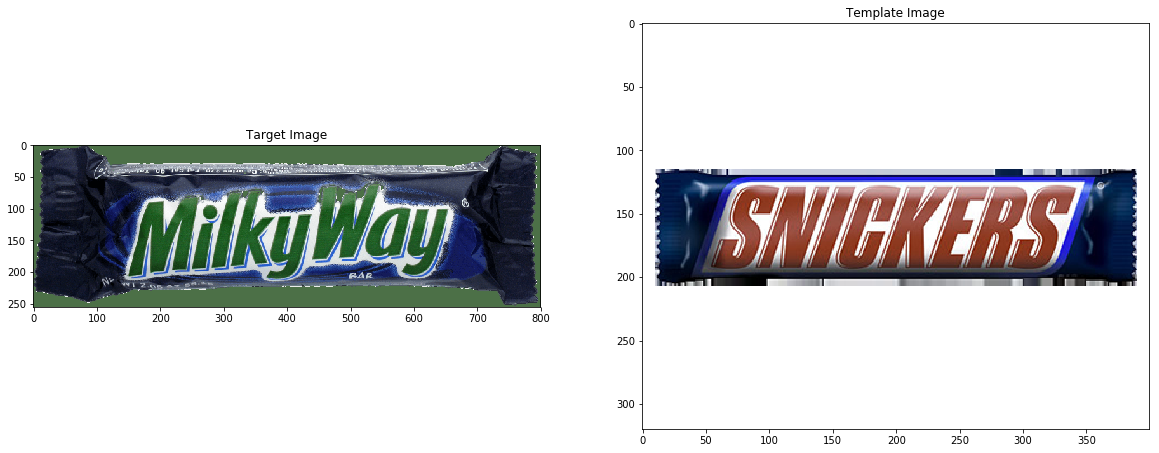

In [20]:
plot_images(img_template2, img_template3)

In [16]:
keypoints_target, descriptors_target, keypoints_template1, descriptors_template1 = extract_keypoints_and_descriptors(img_target, img_template)

In [21]:
keypoints_template2, descriptors_template2, keypoints_template3, descriptors_template3 = extract_keypoints_and_descriptors(img_template2, img_template3)

In [17]:
plot_best_matches1, best_matches1 = get_best_matches(descriptors_target, descriptors_template1, ratio=0.65)

In [22]:
plot_best_matches2, best_matches2 = get_best_matches(descriptors_target, descriptors_template2, ratio=0.65)

In [23]:
plot_best_matches3, best_matches3 = get_best_matches(descriptors_target, descriptors_template3, ratio=0.65)

In [18]:
draw_closest_matches(img_target, img_template, keypoints_target, keypoints_template1, plot_best_matches1)

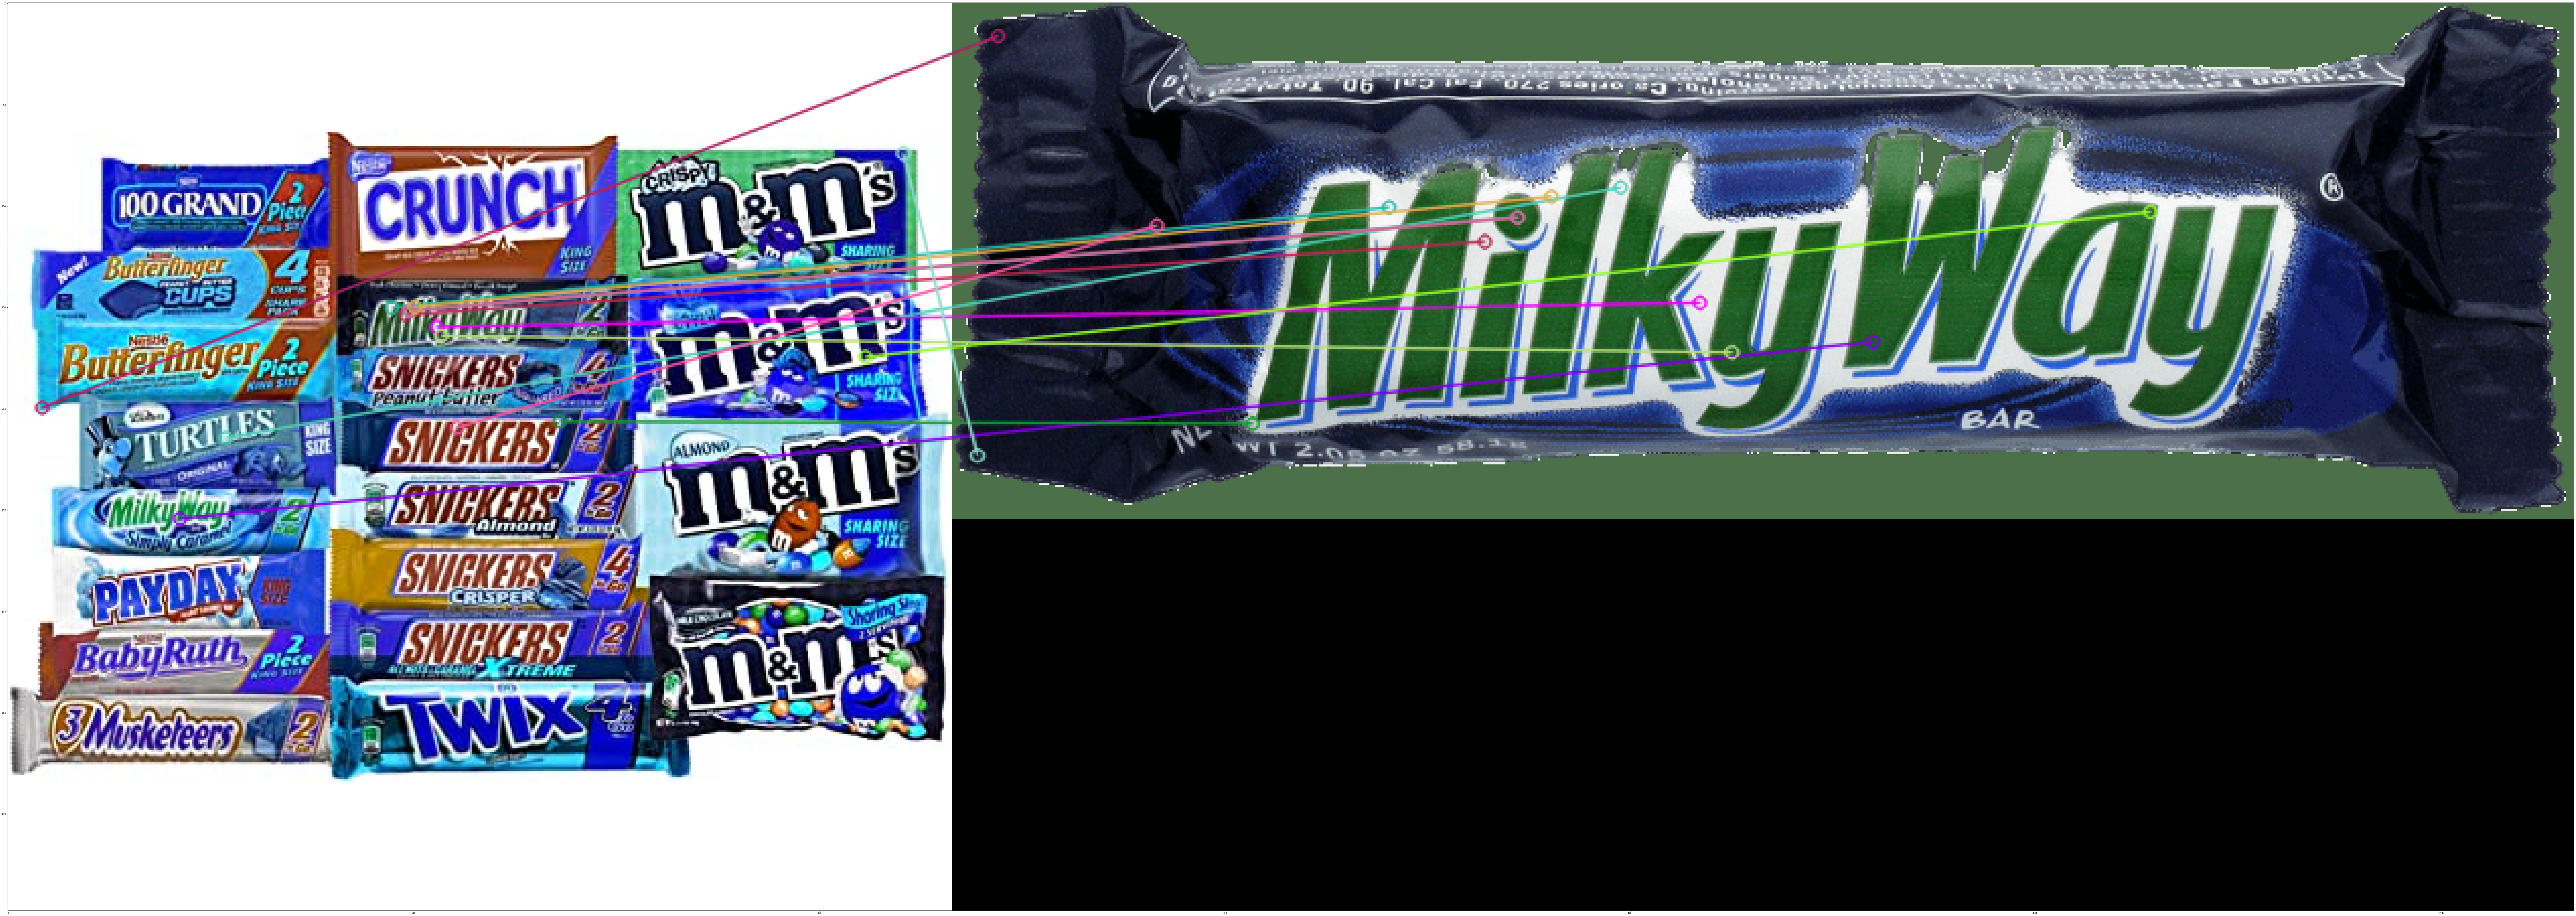

In [24]:
draw_closest_matches(img_target, img_template2, keypoints_target, keypoints_template2, plot_best_matches2)

In [25]:
draw_closest_matches(img_target, img_template3, keypoints_target, keypoints_template3, plot_best_matches3)

In [26]:
correspondences1 = get_correspondences(best_matches1, keypoints_target, keypoints_template1)

In [37]:
models1 = sequential_ransac(correspondences1, 1.5, 4,99,500)

61
51
38
25


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


18
11
7
3


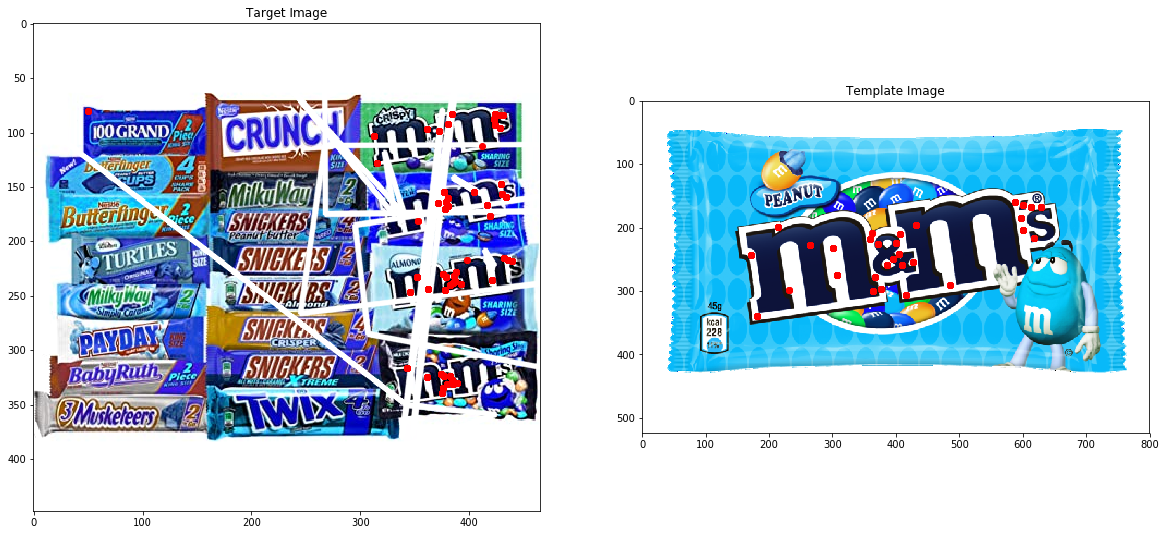

In [40]:
plot_image_correspondences(img_target, img_template, models1)

In [41]:
correspondences2 = get_correspondences(best_matches2, keypoints_target, keypoints_template2)

In [42]:
models2 = sequential_ransac(correspondences2, 1.5, 4,99,500)

7
3


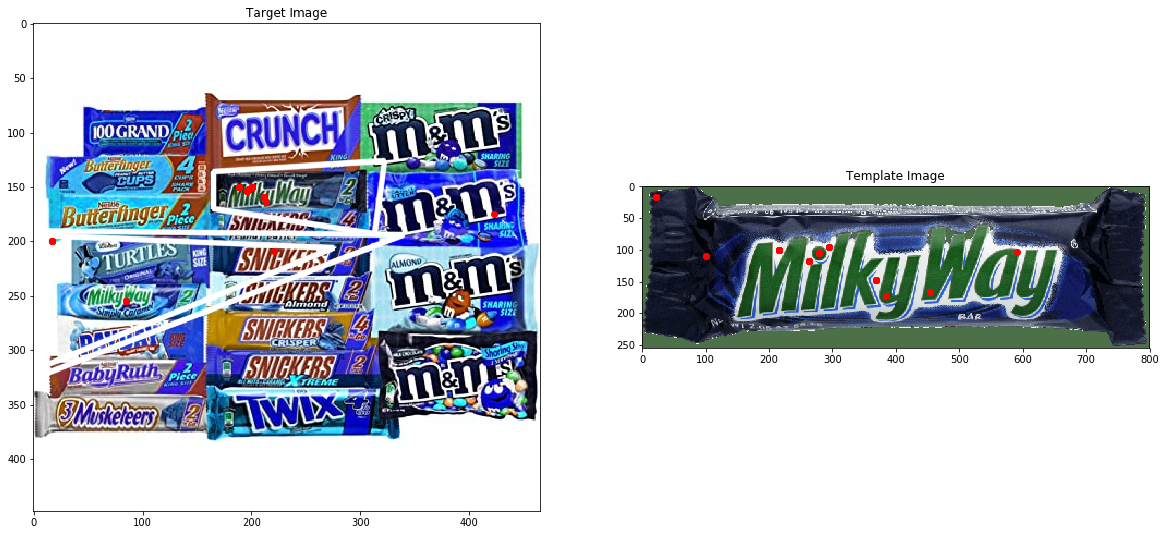

In [45]:
plot_image_correspondences(img_target, img_template2, models2)

In [46]:
correspondences3 = get_correspondences(best_matches3, keypoints_target, keypoints_template3)

In [47]:
models3 = sequential_ransac(correspondences3, 1.5, 4,99,500)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


29
24
19
15
10
6
2


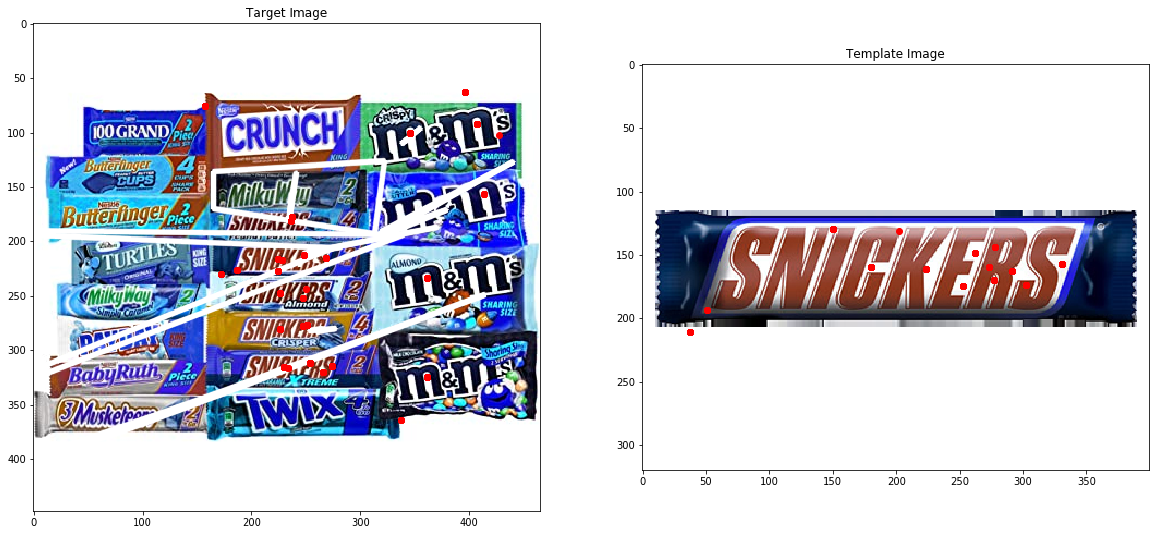

In [48]:
plot_image_correspondences(img_target, img_template3, models3)